In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""
test=""
z_diff=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "uber"
z_range = "all_z"
key = ""
quantile = ""
test = "background"
z_diff = 0.5


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
z_diff=float(z_diff)

In [5]:
if "foreground" in test:
    members=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])>=z_diff]
elif "background" in test:
    members=background=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])<=-z_diff]
elif test=="":
    pass
else:
    raise TypeError

In [6]:
if vol!="uber":
    members=shapes

In [7]:
if quantile!="":
    i=int(quantile)

In [8]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [9]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [10]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [11]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [12]:
NBINS=10

In [13]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [14]:
len(shapes)

1079244

In [15]:
len(members)

78

In [16]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [17]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=members[members['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [18]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [19]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [20]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

4it [00:00, 39.50it/s]

15it [00:00, 48.41it/s]

24it [00:00, 56.05it/s]

35it [00:00, 65.12it/s]

46it [00:00, 73.33it/s]

57it [00:00, 80.42it/s]

68it [00:00, 86.28it/s]

79it [00:00, 90.69it/s]

90it [00:00, 94.13it/s]

101it [00:01, 97.15it/s]

112it [00:01, 99.41it/s]

123it [00:01, 100.52it/s]

134it [00:01, 101.08it/s]

145it [00:01, 101.96it/s]

156it [00:01, 102.66it/s]

167it [00:01, 103.00it/s]

178it [00:01, 101.57it/s]

189it [00:01, 102.15it/s]

200it [00:02, 102.21it/s]

211it [00:02, 102.71it/s]

222it [00:02, 103.26it/s]

233it [00:02, 103.01it/s]

244it [00:02, 103.26it/s]

255it [00:02, 103.67it/s]

266it [00:02, 103.33it/s]

277it [00:02, 103.40it/s]

288it [00:02, 103.13it/s]

299it [00:02, 102.73it/s]

310it [00:03, 103.14it/s]

321it [00:03, 102.79it/s]

332it [00:03, 102.89it/s]

343it [00:03, 103.18it/s]

354it [00:03, 102.84it/s]

365it [00:03, 103.04it/s]

376it [00:03, 103.14it/s]

387it [00:03, 103.37it/s]

398it [00:03, 103.13it/s]

409it [00:04, 100.04it/s]

420it [00:04, 100.81it/s]

431it [00:04, 101.69it/s]

442it [00:04, 101.98it/s]

453it [00:04, 102.39it/s]

464it [00:04, 103.29it/s]

475it [00:04, 103.67it/s]

486it [00:04, 103.62it/s]

497it [00:04, 103.40it/s]

508it [00:05, 103.12it/s]

519it [00:05, 103.22it/s]

530it [00:05, 103.97it/s]

541it [00:05, 103.58it/s]

552it [00:05, 103.63it/s]

563it [00:05, 103.83it/s]

574it [00:05, 104.02it/s]

585it [00:05, 103.92it/s]

596it [00:05, 104.20it/s]

607it [00:05, 103.85it/s]

618it [00:06, 103.47it/s]

629it [00:06, 103.49it/s]

640it [00:06, 103.05it/s]

651it [00:06, 103.06it/s]

662it [00:06, 103.10it/s]

673it [00:06, 103.23it/s]

684it [00:06, 103.14it/s]

695it [00:06, 103.17it/s]

706it [00:06, 102.98it/s]

717it [00:07, 103.24it/s]

728it [00:07, 103.19it/s]

739it [00:07, 103.66it/s]

750it [00:07, 104.04it/s]

761it [00:07, 104.02it/s]

772it [00:07, 103.45it/s]

783it [00:07, 103.34it/s]

794it [00:07, 103.39it/s]

805it [00:07, 103.76it/s]

816it [00:07, 104.05it/s]

827it [00:08, 104.36it/s]

838it [00:08, 101.08it/s]

849it [00:08, 93.09it/s] 

859it [00:08, 94.93it/s]

870it [00:08, 97.32it/s]

881it [00:08, 98.81it/s]

892it [00:08, 100.07it/s]

903it [00:08, 101.27it/s]

914it [00:08, 95.40it/s] 

925it [00:09, 98.24it/s]

936it [00:09, 99.82it/s]

947it [00:09, 101.03it/s]

958it [00:09, 102.03it/s]

969it [00:09, 102.56it/s]

980it [00:09, 103.26it/s]

991it [00:09, 103.44it/s]

1002it [00:09, 103.67it/s]

1013it [00:09, 103.82it/s]

1024it [00:10, 100.08it/s]

1035it [00:10, 101.02it/s]

1046it [00:10, 101.13it/s]

1057it [00:10, 101.61it/s]

1068it [00:10, 102.45it/s]

1079it [00:10, 102.70it/s]

1090it [00:10, 102.36it/s]

1101it [00:10, 102.60it/s]

1112it [00:10, 102.82it/s]

1123it [00:11, 102.97it/s]

1134it [00:11, 102.81it/s]

1145it [00:11, 102.81it/s]

1156it [00:11, 103.02it/s]

1167it [00:11, 103.04it/s]

1178it [00:11, 102.76it/s]

1189it [00:11, 103.18it/s]

1200it [00:11, 103.11it/s]

1211it [00:11, 102.89it/s]

1222it [00:11, 102.87it/s]

1233it [00:12, 102.96it/s]

1244it [00:12, 103.12it/s]

1255it [00:12, 102.74it/s]

1266it [00:12, 103.04it/s]

1277it [00:12, 103.53it/s]

1288it [00:12, 103.64it/s]

1299it [00:12, 103.68it/s]

1310it [00:12, 103.79it/s]

1321it [00:12, 103.40it/s]

1332it [00:13, 103.78it/s]

1343it [00:13, 103.50it/s]

1354it [00:13, 103.19it/s]

1365it [00:13, 103.46it/s]

1376it [00:13, 102.83it/s]

1387it [00:13, 102.71it/s]

1398it [00:13, 103.04it/s]

1409it [00:13, 103.06it/s]

1420it [00:13, 103.15it/s]

1431it [00:14, 103.97it/s]

1442it [00:14, 104.22it/s]

1453it [00:14, 104.36it/s]

1464it [00:14, 103.83it/s]

1475it [00:14, 103.97it/s]

1486it [00:14, 104.28it/s]

1497it [00:14, 104.33it/s]

1508it [00:14, 104.67it/s]

1519it [00:14, 105.12it/s]

1530it [00:14, 104.67it/s]

1541it [00:15, 101.49it/s]

1552it [00:15, 102.33it/s]

1563it [00:15, 103.23it/s]

1574it [00:15, 102.34it/s]

1585it [00:15, 103.34it/s]

1596it [00:15, 104.16it/s]

1607it [00:15, 104.32it/s]

1618it [00:15, 104.41it/s]

1629it [00:15, 104.25it/s]

1640it [00:16, 104.31it/s]

1651it [00:16, 104.18it/s]

1662it [00:16, 104.13it/s]

1673it [00:16, 104.45it/s]

1684it [00:16, 104.36it/s]

1695it [00:16, 104.42it/s]

1706it [00:16, 104.92it/s]

1717it [00:16, 104.35it/s]

1728it [00:16, 104.01it/s]

1739it [00:16, 103.84it/s]

1750it [00:17, 104.21it/s]

1761it [00:17, 104.35it/s]

1772it [00:17, 104.50it/s]

1783it [00:17, 104.76it/s]

1794it [00:17, 105.17it/s]

1805it [00:17, 104.94it/s]

1816it [00:17, 104.98it/s]

1827it [00:17, 104.72it/s]

1838it [00:17, 104.75it/s]

1849it [00:18, 104.99it/s]

1860it [00:18, 105.08it/s]

1871it [00:18, 104.91it/s]

1882it [00:18, 104.28it/s]

1893it [00:18, 104.30it/s]

1904it [00:18, 103.33it/s]

1915it [00:18, 103.92it/s]

1926it [00:18, 104.49it/s]

1937it [00:18, 104.16it/s]

1948it [00:18, 103.34it/s]

1959it [00:19, 103.42it/s]

1970it [00:19, 103.87it/s]

1981it [00:19, 103.54it/s]

1992it [00:19, 103.97it/s]

2003it [00:19, 103.60it/s]

2014it [00:19, 104.05it/s]

2025it [00:19, 104.94it/s]

2036it [00:19, 105.03it/s]

2047it [00:19, 104.86it/s]

2058it [00:20, 104.71it/s]

2069it [00:20, 104.59it/s]

2080it [00:20, 104.83it/s]

2091it [00:20, 105.03it/s]

2102it [00:20, 105.02it/s]

2113it [00:20, 104.90it/s]

2124it [00:20, 104.90it/s]

2135it [00:20, 105.64it/s]

2146it [00:20, 105.34it/s]

2157it [00:20, 105.66it/s]

2168it [00:21, 105.79it/s]

2179it [00:21, 105.76it/s]

2190it [00:21, 105.69it/s]

2201it [00:21, 105.45it/s]

2212it [00:21, 105.30it/s]

2223it [00:21, 105.52it/s]

2234it [00:21, 102.69it/s]

2245it [00:21, 99.29it/s] 

2256it [00:21, 100.32it/s]

2267it [00:22, 101.63it/s]

2278it [00:22, 100.05it/s]

2289it [00:22, 101.34it/s]

2300it [00:22, 102.10it/s]

2311it [00:22, 102.82it/s]

2322it [00:22, 103.68it/s]

2333it [00:22, 104.14it/s]

2344it [00:22, 104.44it/s]

2355it [00:22, 104.57it/s]

2366it [00:22, 105.02it/s]

2377it [00:23, 104.85it/s]

2388it [00:23, 104.51it/s]

2399it [00:23, 104.56it/s]

2410it [00:23, 105.08it/s]

2421it [00:23, 105.12it/s]

2432it [00:23, 105.00it/s]

2443it [00:23, 105.13it/s]

2454it [00:23, 105.23it/s]

2465it [00:23, 105.18it/s]

2476it [00:24, 105.08it/s]

2487it [00:24, 104.92it/s]

2498it [00:24, 105.05it/s]

2509it [00:24, 104.57it/s]

2520it [00:24, 104.65it/s]

2531it [00:24, 104.75it/s]

2542it [00:24, 104.82it/s]

2553it [00:24, 105.24it/s]

2564it [00:24, 104.46it/s]

2575it [00:24, 104.08it/s]

2586it [00:25, 104.25it/s]

2597it [00:25, 104.36it/s]

2608it [00:25, 101.92it/s]

2619it [00:25, 102.49it/s]

2630it [00:25, 103.47it/s]

2641it [00:25, 103.99it/s]

2652it [00:25, 103.78it/s]

2663it [00:25, 101.54it/s]

2674it [00:25, 99.59it/s] 

2685it [00:26, 100.95it/s]

2696it [00:26, 101.26it/s]

2707it [00:26, 101.68it/s]

2718it [00:26, 101.90it/s]

2729it [00:26, 102.30it/s]

2740it [00:26, 102.33it/s]

2751it [00:26, 102.73it/s]

2762it [00:26, 102.83it/s]

2773it [00:26, 102.87it/s]

2784it [00:27, 102.88it/s]

2795it [00:27, 103.13it/s]

2806it [00:27, 100.49it/s]

2817it [00:27, 101.43it/s]

2828it [00:27, 102.22it/s]

2839it [00:27, 102.30it/s]

2850it [00:27, 102.52it/s]

2861it [00:27, 102.09it/s]

2872it [00:27, 102.18it/s]

2883it [00:27, 102.92it/s]

2894it [00:28, 102.98it/s]

2905it [00:28, 102.89it/s]

2916it [00:28, 103.02it/s]

2927it [00:28, 103.42it/s]

2938it [00:28, 103.27it/s]

2949it [00:28, 100.14it/s]

2960it [00:28, 101.23it/s]

2971it [00:28, 102.00it/s]

2982it [00:28, 102.15it/s]

2993it [00:29, 101.60it/s]

3004it [00:29, 101.80it/s]

3015it [00:29, 101.97it/s]

3026it [00:29, 102.34it/s]

3037it [00:29, 102.77it/s]

3048it [00:29, 102.99it/s]

3059it [00:29, 103.08it/s]

3070it [00:29, 103.59it/s]

3081it [00:29, 103.44it/s]

3092it [00:30, 103.30it/s]

3103it [00:30, 103.39it/s]

3114it [00:30, 103.49it/s]

3125it [00:30, 100.48it/s]

3136it [00:30, 101.59it/s]

3147it [00:30, 102.05it/s]

3158it [00:30, 102.31it/s]

3169it [00:30, 102.88it/s]

3180it [00:30, 103.21it/s]

3191it [00:30, 103.74it/s]

3202it [00:31, 103.81it/s]

3213it [00:31, 103.57it/s]

3224it [00:31, 102.79it/s]

3235it [00:31, 102.78it/s]

3246it [00:31, 103.01it/s]

3257it [00:31, 103.39it/s]

3268it [00:31, 103.73it/s]

3279it [00:31, 103.90it/s]

3290it [00:31, 103.39it/s]

3301it [00:32, 103.31it/s]

3312it [00:32, 102.94it/s]

3323it [00:32, 102.65it/s]

3334it [00:32, 103.05it/s]

3345it [00:32, 102.66it/s]

3356it [00:32, 102.34it/s]

3367it [00:32, 102.82it/s]

3378it [00:32, 102.55it/s]

3389it [00:32, 102.59it/s]

3400it [00:33, 102.78it/s]

3411it [00:33, 102.40it/s]

3422it [00:33, 102.71it/s]

3433it [00:33, 100.62it/s]

3444it [00:33, 101.05it/s]

3455it [00:33, 101.68it/s]

3466it [00:33, 102.47it/s]

3477it [00:33, 101.72it/s]

3488it [00:33, 102.39it/s]

3499it [00:34, 102.07it/s]

3510it [00:34, 102.35it/s]

3521it [00:34, 103.11it/s]

3532it [00:34, 102.49it/s]

3543it [00:34, 102.92it/s]

3554it [00:34, 102.48it/s]

3565it [00:34, 102.58it/s]

3576it [00:34, 102.68it/s]

3587it [00:34, 102.28it/s]

3598it [00:34, 102.66it/s]

3609it [00:35, 98.23it/s] 

3620it [00:35, 99.65it/s]

3630it [00:35, 97.60it/s]

3641it [00:35, 99.18it/s]

3652it [00:35, 99.78it/s]

3663it [00:35, 101.10it/s]

3674it [00:35, 101.50it/s]

3685it [00:35, 101.68it/s]

3696it [00:35, 101.85it/s]

3707it [00:36, 102.34it/s]

3718it [00:36, 102.44it/s]

3729it [00:36, 102.59it/s]

3740it [00:36, 102.32it/s]

3751it [00:36, 102.36it/s]

3762it [00:36, 102.64it/s]

3773it [00:36, 102.60it/s]

3784it [00:36, 103.32it/s]

3795it [00:36, 102.93it/s]

3806it [00:37, 103.44it/s]

3817it [00:37, 103.17it/s]

3828it [00:37, 103.28it/s]

3839it [00:37, 103.39it/s]

3850it [00:37, 103.14it/s]

3861it [00:37, 101.01it/s]

3872it [00:37, 101.52it/s]

3883it [00:37, 101.73it/s]

3894it [00:37, 102.35it/s]

3905it [00:37, 102.50it/s]

3916it [00:38, 102.26it/s]

3927it [00:38, 102.27it/s]

3938it [00:38, 102.54it/s]

3949it [00:38, 102.52it/s]

3960it [00:38, 102.66it/s]

3971it [00:38, 103.06it/s]

3982it [00:38, 103.21it/s]

3993it [00:38, 103.81it/s]

4004it [00:38, 103.89it/s]

4015it [00:39, 103.95it/s]

4026it [00:39, 104.16it/s]

4037it [00:39, 103.97it/s]

4048it [00:39, 104.45it/s]

4059it [00:39, 103.98it/s]

4070it [00:39, 103.57it/s]

4081it [00:39, 104.06it/s]

4092it [00:39, 103.93it/s]

4103it [00:39, 101.01it/s]

4114it [00:40, 101.88it/s]

4125it [00:40, 102.55it/s]

4136it [00:40, 100.32it/s]

4147it [00:40, 101.88it/s]

4158it [00:40, 102.44it/s]

4169it [00:40, 102.88it/s]

4180it [00:40, 103.00it/s]

4191it [00:40, 103.33it/s]

4202it [00:40, 103.65it/s]

4213it [00:40, 104.34it/s]

4224it [00:41, 104.00it/s]

4235it [00:41, 104.07it/s]

4246it [00:41, 104.21it/s]

4257it [00:41, 104.22it/s]

4268it [00:41, 101.09it/s]

4279it [00:41, 102.26it/s]

4290it [00:41, 99.99it/s] 

4301it [00:41, 99.98it/s]

4312it [00:41, 100.66it/s]

4323it [00:42, 101.78it/s]

4334it [00:42, 102.88it/s]

4345it [00:42, 103.12it/s]

4356it [00:42, 103.13it/s]

4367it [00:42, 103.27it/s]

4378it [00:42, 103.81it/s]

4389it [00:42, 103.71it/s]

4400it [00:42, 104.04it/s]

4411it [00:42, 104.17it/s]

4422it [00:42, 104.22it/s]

4433it [00:43, 104.41it/s]

4444it [00:43, 101.54it/s]

4455it [00:43, 102.14it/s]

4466it [00:43, 102.95it/s]

4477it [00:43, 103.22it/s]

4488it [00:43, 103.75it/s]

4499it [00:43, 104.01it/s]

4510it [00:43, 104.26it/s]

4521it [00:43, 103.77it/s]

4532it [00:44, 103.59it/s]

4543it [00:44, 103.49it/s]

4554it [00:44, 102.60it/s]

4565it [00:44, 102.78it/s]

4576it [00:44, 103.00it/s]

4587it [00:44, 103.44it/s]

4598it [00:44, 103.35it/s]

4609it [00:44, 103.78it/s]

4620it [00:44, 103.85it/s]

4631it [00:45, 103.41it/s]

4642it [00:45, 103.49it/s]

4653it [00:45, 103.58it/s]

4664it [00:45, 103.59it/s]

4675it [00:45, 103.56it/s]

4686it [00:45, 103.46it/s]

4697it [00:45, 103.80it/s]

4708it [00:45, 103.50it/s]

4719it [00:45, 103.20it/s]

4730it [00:45, 103.57it/s]

4741it [00:46, 103.42it/s]

4752it [00:46, 103.61it/s]

4763it [00:46, 103.32it/s]

4774it [00:46, 103.74it/s]

4785it [00:46, 104.02it/s]

4796it [00:46, 104.07it/s]

4807it [00:46, 104.23it/s]

4818it [00:46, 104.34it/s]

4829it [00:46, 104.50it/s]

4840it [00:47, 105.03it/s]

4851it [00:47, 104.72it/s]

4862it [00:47, 104.57it/s]

4873it [00:47, 104.80it/s]

4884it [00:47, 104.52it/s]

4895it [00:47, 104.82it/s]

4906it [00:47, 104.88it/s]

4917it [00:47, 104.71it/s]

4928it [00:47, 104.75it/s]

4939it [00:47, 104.42it/s]

4950it [00:48, 104.46it/s]

4961it [00:48, 104.47it/s]

4972it [00:48, 104.53it/s]

4983it [00:48, 104.71it/s]

4994it [00:48, 105.07it/s]

5005it [00:48, 104.58it/s]

5016it [00:48, 104.75it/s]

5027it [00:48, 104.79it/s]

5038it [00:48, 104.86it/s]

5049it [00:49, 105.03it/s]

5060it [00:49, 104.84it/s]

5071it [00:49, 104.51it/s]

5082it [00:49, 104.28it/s]

5093it [00:49, 103.98it/s]

5104it [00:49, 104.15it/s]

5115it [00:49, 104.23it/s]

5126it [00:49, 104.18it/s]

5137it [00:49, 104.42it/s]

5148it [00:49, 104.25it/s]

5159it [00:50, 104.07it/s]

5170it [00:50, 104.62it/s]

5181it [00:50, 104.28it/s]

5192it [00:50, 104.04it/s]

5203it [00:50, 104.22it/s]

5214it [00:50, 104.46it/s]

5225it [00:50, 104.23it/s]

5236it [00:50, 104.02it/s]

5247it [00:50, 104.19it/s]

5258it [00:51, 103.84it/s]

5269it [00:51, 103.88it/s]

5280it [00:51, 103.47it/s]

5291it [00:51, 103.37it/s]

5302it [00:51, 103.51it/s]

5313it [00:51, 103.71it/s]

5324it [00:51, 103.68it/s]

5335it [00:51, 103.52it/s]

5346it [00:51, 103.43it/s]

5357it [00:51, 103.36it/s]

5368it [00:52, 103.71it/s]

5379it [00:52, 104.27it/s]

5390it [00:52, 104.41it/s]

5401it [00:52, 104.41it/s]

5412it [00:52, 104.23it/s]

5423it [00:52, 100.76it/s]

5434it [00:52, 101.53it/s]

5445it [00:52, 102.31it/s]

5456it [00:52, 102.79it/s]

5467it [00:53, 101.06it/s]

5478it [00:53, 100.94it/s]

5489it [00:53, 98.10it/s] 

5500it [00:53, 99.43it/s]

5511it [00:53, 100.60it/s]

5522it [00:53, 101.55it/s]

5533it [00:53, 101.67it/s]

5544it [00:53, 101.99it/s]

5555it [00:53, 102.10it/s]

5566it [00:54, 102.48it/s]

5577it [00:54, 102.55it/s]

5588it [00:54, 103.17it/s]

5599it [00:54, 103.48it/s]

5610it [00:54, 103.18it/s]

5621it [00:54, 103.28it/s]

5632it [00:54, 103.40it/s]

5643it [00:54, 103.04it/s]

5654it [00:54, 103.46it/s]

5665it [00:55, 103.46it/s]

5676it [00:55, 103.64it/s]

5687it [00:55, 103.25it/s]

5698it [00:55, 102.63it/s]

5709it [00:55, 102.66it/s]

5720it [00:55, 102.73it/s]

5731it [00:55, 102.94it/s]

5742it [00:55, 102.86it/s]

5753it [00:55, 102.85it/s]

5764it [00:55, 103.02it/s]

5775it [00:56, 103.36it/s]

5786it [00:56, 103.11it/s]

5797it [00:56, 102.80it/s]

5808it [00:56, 103.39it/s]

5819it [00:56, 102.73it/s]

5830it [00:56, 102.78it/s]

5841it [00:56, 102.87it/s]

5852it [00:56, 95.65it/s] 

5862it [00:56, 96.85it/s]

5872it [00:57, 97.57it/s]

5883it [00:57, 99.09it/s]

5894it [00:57, 100.48it/s]

5905it [00:57, 101.02it/s]

5916it [00:57, 101.56it/s]

5927it [00:57, 102.00it/s]

5938it [00:57, 102.74it/s]

5949it [00:57, 102.67it/s]

5960it [00:57, 103.02it/s]

5971it [00:58, 102.72it/s]

5982it [00:58, 102.94it/s]

5993it [00:58, 101.53it/s]

6004it [00:58, 102.02it/s]

6015it [00:58, 102.57it/s]

6026it [00:58, 102.90it/s]

6037it [00:58, 102.58it/s]

6048it [00:58, 102.51it/s]

6059it [00:58, 102.52it/s]

6070it [00:58, 102.86it/s]

6081it [00:59, 103.03it/s]

6092it [00:59, 103.53it/s]

6103it [00:59, 103.58it/s]

6114it [00:59, 103.28it/s]

6125it [00:59, 103.58it/s]

6136it [00:59, 103.61it/s]

6147it [00:59, 103.73it/s]

6158it [00:59, 103.92it/s]

6169it [00:59, 103.27it/s]

6180it [01:00, 102.95it/s]

6191it [01:00, 103.14it/s]

6202it [01:00, 102.79it/s]

6213it [01:00, 102.50it/s]

6224it [01:00, 103.10it/s]

6235it [01:00, 102.92it/s]

6246it [01:00, 103.33it/s]

6257it [01:00, 103.37it/s]

6268it [01:00, 103.03it/s]

6279it [01:00, 102.90it/s]

6290it [01:01, 103.26it/s]

6301it [01:01, 103.23it/s]

6312it [01:01, 102.87it/s]

6323it [01:01, 103.07it/s]

6334it [01:01, 103.75it/s]

6345it [01:01, 104.00it/s]

6356it [01:01, 104.14it/s]

6367it [01:01, 104.02it/s]

6378it [01:01, 104.31it/s]

6389it [01:02, 104.09it/s]

6400it [01:02, 103.70it/s]

6411it [01:02, 103.81it/s]

6422it [01:02, 103.65it/s]

6433it [01:02, 103.41it/s]

6444it [01:02, 103.18it/s]

6455it [01:02, 103.32it/s]

6466it [01:02, 103.18it/s]

6477it [01:02, 103.18it/s]

6488it [01:03, 100.64it/s]

6499it [01:03, 101.16it/s]

6510it [01:03, 101.50it/s]

6521it [01:03, 102.22it/s]

6532it [01:03, 102.49it/s]

6543it [01:03, 102.38it/s]

6554it [01:03, 103.08it/s]

6565it [01:03, 103.22it/s]

6576it [01:03, 103.24it/s]

6587it [01:03, 103.15it/s]

6598it [01:04, 103.02it/s]

6609it [01:04, 103.40it/s]

6620it [01:04, 102.99it/s]

6631it [01:04, 103.13it/s]

6642it [01:04, 103.27it/s]

6653it [01:04, 103.08it/s]

6664it [01:04, 103.67it/s]

6675it [01:04, 103.68it/s]

6686it [01:04, 103.55it/s]

6697it [01:05, 103.81it/s]

6708it [01:05, 103.56it/s]

6719it [01:05, 103.39it/s]

6730it [01:05, 103.44it/s]

6741it [01:05, 102.93it/s]

6752it [01:05, 103.24it/s]

6763it [01:05, 102.77it/s]

6774it [01:05, 102.73it/s]

6785it [01:05, 103.23it/s]

6796it [01:06, 103.05it/s]

6807it [01:06, 103.00it/s]

6818it [01:06, 103.06it/s]

6829it [01:06, 103.40it/s]

6840it [01:06, 103.31it/s]

6851it [01:06, 103.45it/s]

6862it [01:06, 103.28it/s]

6873it [01:06, 103.02it/s]

6884it [01:06, 103.00it/s]

6895it [01:06, 103.00it/s]

6906it [01:07, 103.62it/s]

6917it [01:07, 104.02it/s]

6928it [01:07, 103.95it/s]

6939it [01:07, 103.64it/s]

6950it [01:07, 103.40it/s]

6961it [01:07, 103.27it/s]

6972it [01:07, 103.81it/s]

6983it [01:07, 103.23it/s]

6994it [01:07, 103.17it/s]

7005it [01:08, 103.38it/s]

7016it [01:08, 103.32it/s]

7027it [01:08, 103.38it/s]

7038it [01:08, 103.25it/s]

7049it [01:08, 103.19it/s]

7060it [01:08, 103.62it/s]

7071it [01:08, 103.62it/s]

7082it [01:08, 103.77it/s]

7093it [01:08, 103.81it/s]

7104it [01:08, 103.31it/s]

7115it [01:09, 103.24it/s]

7126it [01:09, 102.96it/s]

7137it [01:09, 103.27it/s]

7148it [01:09, 103.60it/s]

7159it [01:09, 103.54it/s]

7170it [01:09, 103.61it/s]

7181it [01:09, 103.52it/s]

7192it [01:09, 103.79it/s]

7203it [01:09, 103.74it/s]

7214it [01:10, 102.75it/s]

7225it [01:10, 103.02it/s]

7236it [01:10, 102.91it/s]

7247it [01:10, 102.91it/s]

7258it [01:10, 103.77it/s]

7269it [01:10, 103.36it/s]

7280it [01:10, 103.23it/s]

7291it [01:10, 103.26it/s]

7302it [01:10, 102.87it/s]

7313it [01:11, 103.25it/s]

7324it [01:11, 103.08it/s]

7335it [01:11, 103.24it/s]

7346it [01:11, 103.69it/s]

7357it [01:11, 103.59it/s]

7368it [01:11, 103.06it/s]

7379it [01:11, 103.21it/s]

7390it [01:11, 103.10it/s]

7401it [01:11, 103.42it/s]

7412it [01:11, 103.76it/s]

7423it [01:12, 103.90it/s]

7434it [01:12, 103.72it/s]

7445it [01:12, 103.35it/s]

7456it [01:12, 103.38it/s]

7467it [01:12, 103.69it/s]

7478it [01:12, 103.74it/s]

7489it [01:12, 103.66it/s]

7500it [01:12, 103.77it/s]

7511it [01:12, 103.76it/s]

7522it [01:13, 103.64it/s]

7533it [01:13, 103.74it/s]

7544it [01:13, 104.08it/s]

7555it [01:13, 103.41it/s]

7566it [01:13, 103.43it/s]

7577it [01:13, 103.37it/s]

7588it [01:13, 103.51it/s]

7599it [01:13, 104.17it/s]

7610it [01:13, 103.87it/s]

7621it [01:13, 103.55it/s]

7632it [01:14, 103.69it/s]

7643it [01:14, 103.90it/s]

7654it [01:14, 104.12it/s]

7665it [01:14, 104.13it/s]

7676it [01:14, 104.30it/s]

7687it [01:14, 104.40it/s]

7698it [01:14, 104.07it/s]

7709it [01:14, 103.91it/s]

7720it [01:14, 103.70it/s]

7731it [01:15, 103.87it/s]

7742it [01:15, 103.37it/s]

7753it [01:15, 103.29it/s]

7764it [01:15, 103.66it/s]

7775it [01:15, 104.00it/s]

7786it [01:15, 104.53it/s]

7797it [01:15, 104.04it/s]

7808it [01:15, 104.01it/s]

7819it [01:15, 103.83it/s]

7830it [01:15, 103.87it/s]

7841it [01:16, 104.24it/s]

7852it [01:16, 103.93it/s]

7863it [01:16, 103.88it/s]

7874it [01:16, 104.09it/s]

7885it [01:16, 103.82it/s]

7896it [01:16, 104.19it/s]

7907it [01:16, 104.06it/s]

7918it [01:16, 103.62it/s]

7929it [01:16, 103.89it/s]

7940it [01:17, 101.16it/s]

7951it [01:17, 99.77it/s] 

7961it [01:17, 99.63it/s]

7972it [01:17, 100.04it/s]

7983it [01:17, 101.57it/s]

7994it [01:17, 102.65it/s]

8005it [01:17, 99.54it/s] 

8015it [01:17, 99.65it/s]

8026it [01:17, 101.05it/s]

8037it [01:18, 101.64it/s]

8048it [01:18, 102.40it/s]

8059it [01:18, 102.76it/s]

8070it [01:18, 103.09it/s]

8081it [01:18, 103.63it/s]

8092it [01:18, 104.25it/s]

8103it [01:18, 104.23it/s]

8114it [01:18, 104.18it/s]

8125it [01:18, 104.00it/s]

8136it [01:18, 103.91it/s]

8147it [01:19, 103.91it/s]

8158it [01:19, 103.96it/s]

8169it [01:19, 103.79it/s]

8180it [01:19, 103.99it/s]

8191it [01:19, 104.37it/s]

8202it [01:19, 104.50it/s]

8213it [01:19, 104.55it/s]

8224it [01:19, 104.32it/s]

8235it [01:19, 104.41it/s]

8246it [01:20, 104.18it/s]

8257it [01:20, 104.27it/s]

8268it [01:20, 104.62it/s]

8279it [01:20, 104.22it/s]

8290it [01:20, 104.23it/s]

8301it [01:20, 104.53it/s]

8312it [01:20, 104.49it/s]

8323it [01:20, 104.36it/s]

8334it [01:20, 104.16it/s]

8345it [01:20, 104.28it/s]

8356it [01:21, 104.29it/s]

8367it [01:21, 104.25it/s]

8378it [01:21, 103.47it/s]

8389it [01:21, 103.56it/s]

8400it [01:21, 103.74it/s]

8411it [01:21, 103.86it/s]

8422it [01:21, 104.35it/s]

8433it [01:21, 102.47it/s]

8444it [01:21, 103.07it/s]

8455it [01:22, 103.30it/s]

8466it [01:22, 103.04it/s]

8477it [01:22, 103.42it/s]

8488it [01:22, 103.50it/s]

8499it [01:22, 103.76it/s]

8510it [01:22, 103.69it/s]

8521it [01:22, 103.88it/s]

8532it [01:22, 103.23it/s]

8543it [01:22, 97.91it/s] 

8554it [01:23, 99.18it/s]

8565it [01:23, 100.19it/s]

8576it [01:23, 100.85it/s]

8587it [01:23, 101.40it/s]

8598it [01:23, 101.96it/s]

8609it [01:23, 101.96it/s]

8620it [01:23, 101.83it/s]

8631it [01:23, 97.65it/s] 

8641it [01:23, 93.25it/s]

8651it [01:24, 94.29it/s]

8662it [01:24, 96.80it/s]

8673it [01:24, 98.30it/s]

8684it [01:24, 99.05it/s]

8694it [01:24, 92.62it/s]

8704it [01:24, 88.64it/s]

8713it [01:24, 86.04it/s]

8722it [01:24, 86.14it/s]

8733it [01:24, 90.82it/s]

8744it [01:25, 94.36it/s]

8755it [01:25, 96.99it/s]

8766it [01:25, 98.46it/s]

8777it [01:25, 99.35it/s]

8787it [01:25, 96.68it/s]

8797it [01:25, 88.22it/s]

8807it [01:25, 83.08it/s]

8816it [01:25, 78.53it/s]

8825it [01:25, 76.73it/s]

8833it [01:26, 75.32it/s]

8841it [01:26, 74.99it/s]

8849it [01:26, 73.84it/s]

8857it [01:26, 73.33it/s]

8865it [01:26, 73.58it/s]

8873it [01:26, 73.71it/s]

8881it [01:26, 73.00it/s]

8889it [01:26, 73.20it/s]

8897it [01:26, 72.73it/s]

8905it [01:27, 73.00it/s]

8913it [01:27, 70.69it/s]

8921it [01:27, 70.13it/s]

8929it [01:27, 70.07it/s]

8937it [01:27, 69.66it/s]

8944it [01:27, 69.30it/s]

8951it [01:27, 69.30it/s]

8958it [01:27, 68.99it/s]

8965it [01:27, 68.64it/s]

8972it [01:28, 68.49it/s]

8980it [01:28, 69.07it/s]

8987it [01:28, 68.81it/s]

8994it [01:28, 68.64it/s]

9002it [01:28, 69.22it/s]

9009it [01:28, 69.34it/s]

9016it [01:28, 69.48it/s]

9023it [01:28, 69.21it/s]

9030it [01:28, 69.34it/s]

9037it [01:28, 69.46it/s]

9046it [01:29, 73.68it/s]

9059it [01:29, 82.55it/s]

9071it [01:29, 89.51it/s]

9081it [01:29, 92.20it/s]

9091it [01:29, 90.33it/s]

9101it [01:29, 87.99it/s]

9110it [01:29, 85.60it/s]

9119it [01:29, 84.25it/s]

9130it [01:29, 88.66it/s]

9140it [01:30, 91.73it/s]

9150it [01:30, 92.84it/s]

9160it [01:30, 93.64it/s]

9170it [01:30, 94.43it/s]

9181it [01:30, 95.90it/s]

9191it [01:30, 96.00it/s]

9201it [01:30, 96.43it/s]

9211it [01:30, 96.58it/s]

9221it [01:30, 94.50it/s]

9231it [01:31, 95.95it/s]

9241it [01:31, 97.10it/s]

9251it [01:31, 97.84it/s]

9262it [01:31, 98.89it/s]

9272it [01:31, 98.96it/s]

9283it [01:31, 99.41it/s]

9294it [01:31, 99.70it/s]

9305it [01:31, 99.85it/s]

9316it [01:31, 100.16it/s]

9327it [01:31, 100.18it/s]

9338it [01:32, 99.83it/s] 

9348it [01:32, 99.81it/s]

9358it [01:32, 98.39it/s]

9368it [01:32, 97.63it/s]

9378it [01:32, 97.43it/s]

9389it [01:32, 98.49it/s]

9399it [01:32, 98.26it/s]

9409it [01:32, 98.77it/s]

9419it [01:32, 99.13it/s]

9429it [01:33, 99.12it/s]

9440it [01:33, 99.64it/s]

9450it [01:33, 98.90it/s]

9460it [01:33, 98.96it/s]

9471it [01:33, 99.69it/s]

9481it [01:33, 99.72it/s]

9492it [01:33, 99.60it/s]

9503it [01:33, 99.79it/s]

9514it [01:33, 100.13it/s]

9525it [01:33, 100.37it/s]

9536it [01:34, 100.22it/s]

9547it [01:34, 100.70it/s]

9558it [01:34, 100.64it/s]

9569it [01:34, 100.79it/s]

9580it [01:34, 101.04it/s]

9591it [01:34, 101.21it/s]

9602it [01:34, 101.63it/s]

9613it [01:34, 101.59it/s]

9624it [01:34, 102.68it/s]

9635it [01:35, 102.71it/s]

9646it [01:35, 102.36it/s]

9657it [01:35, 101.53it/s]

9668it [01:35, 101.76it/s]

9679it [01:35, 92.72it/s] 

9689it [01:35, 88.32it/s]

9698it [01:35, 85.15it/s]

9707it [01:35, 70.46it/s]

9715it [01:36, 73.02it/s]

9723it [01:36, 74.55it/s]

9731it [01:36, 76.06it/s]

9740it [01:36, 77.58it/s]

9748it [01:36, 77.86it/s]

9757it [01:36, 80.35it/s]

9768it [01:36, 86.01it/s]

9779it [01:36, 90.22it/s]

9789it [01:36, 92.32it/s]

9800it [01:36, 95.49it/s]

9811it [01:37, 98.05it/s]

9822it [01:37, 99.16it/s]

9833it [01:37, 99.85it/s]

9844it [01:37, 100.73it/s]

9855it [01:37, 100.51it/s]

9866it [01:37, 100.89it/s]

9877it [01:37, 101.15it/s]

9888it [01:37, 101.44it/s]

9899it [01:37, 101.64it/s]

9910it [01:38, 101.57it/s]

9921it [01:38, 102.36it/s]

9932it [01:38, 102.45it/s]

9943it [01:38, 102.39it/s]

9954it [01:38, 102.53it/s]

9965it [01:38, 102.85it/s]

9976it [01:38, 102.39it/s]

9987it [01:38, 102.64it/s]

9998it [01:38, 102.21it/s]

10009it [01:39, 102.55it/s]

10020it [01:39, 102.68it/s]

10031it [01:39, 103.09it/s]

10042it [01:39, 102.78it/s]

10053it [01:39, 102.15it/s]

10064it [01:39, 101.37it/s]

10075it [01:39, 101.67it/s]

10086it [01:39, 102.06it/s]

10097it [01:39, 101.94it/s]

10108it [01:39, 101.60it/s]

10119it [01:40, 102.22it/s]

10130it [01:40, 101.72it/s]

10141it [01:40, 102.22it/s]

10152it [01:40, 102.29it/s]

10163it [01:40, 103.05it/s]

10174it [01:40, 102.98it/s]

10185it [01:40, 102.58it/s]

10196it [01:40, 102.56it/s]

10207it [01:40, 102.46it/s]

10218it [01:41, 102.29it/s]

10229it [01:41, 102.87it/s]

10240it [01:41, 102.73it/s]

10251it [01:41, 102.81it/s]

10262it [01:41, 102.39it/s]

10273it [01:41, 102.55it/s]

10284it [01:41, 102.66it/s]

10295it [01:41, 102.65it/s]

10306it [01:41, 102.91it/s]

10317it [01:42, 102.34it/s]

10328it [01:42, 102.72it/s]

10339it [01:42, 103.58it/s]

10350it [01:42, 103.11it/s]

10361it [01:42, 103.39it/s]

10372it [01:42, 104.01it/s]

10383it [01:42, 103.72it/s]

10394it [01:42, 103.51it/s]

10405it [01:42, 102.87it/s]

10416it [01:42, 102.57it/s]

10427it [01:43, 102.29it/s]

10438it [01:43, 102.52it/s]

10449it [01:43, 103.22it/s]

10460it [01:43, 102.54it/s]

10471it [01:43, 102.82it/s]

10482it [01:43, 102.81it/s]

10493it [01:43, 102.76it/s]

10504it [01:43, 102.31it/s]

10515it [01:43, 102.54it/s]

10526it [01:44, 102.59it/s]

10537it [01:44, 103.08it/s]

10548it [01:44, 102.05it/s]

10559it [01:44, 101.86it/s]

10570it [01:44, 101.89it/s]

10581it [01:44, 101.72it/s]

10592it [01:44, 102.02it/s]

10603it [01:44, 102.11it/s]

10614it [01:44, 101.71it/s]

10625it [01:45, 101.52it/s]

10636it [01:45, 102.05it/s]

10647it [01:45, 102.42it/s]

10658it [01:45, 103.24it/s]

10669it [01:45, 103.75it/s]

10680it [01:45, 103.55it/s]

10691it [01:45, 103.63it/s]

10702it [01:45, 103.06it/s]

10713it [01:45, 103.48it/s]

10724it [01:45, 103.06it/s]

10735it [01:46, 102.74it/s]

10746it [01:46, 103.05it/s]

10757it [01:46, 103.26it/s]

10768it [01:46, 103.65it/s]

10779it [01:46, 103.60it/s]

10790it [01:46, 103.30it/s]

10801it [01:46, 103.28it/s]

10812it [01:46, 103.14it/s]

10823it [01:46, 102.98it/s]

10834it [01:47, 103.01it/s]

10845it [01:47, 102.93it/s]

10856it [01:47, 103.04it/s]

10867it [01:47, 102.24it/s]

10878it [01:47, 102.91it/s]

10889it [01:47, 103.22it/s]

10900it [01:47, 103.28it/s]

10911it [01:47, 103.14it/s]

10922it [01:47, 102.83it/s]

10933it [01:48, 103.24it/s]

10944it [01:48, 102.53it/s]

10955it [01:48, 102.74it/s]

10966it [01:48, 103.15it/s]

10977it [01:48, 102.79it/s]

10988it [01:48, 102.67it/s]

10999it [01:48, 102.44it/s]

11010it [01:48, 102.23it/s]

11021it [01:48, 102.23it/s]

11032it [01:48, 102.35it/s]

11043it [01:49, 102.85it/s]

11054it [01:49, 102.88it/s]

11065it [01:49, 102.34it/s]

11076it [01:49, 103.17it/s]

11087it [01:49, 102.37it/s]

11098it [01:49, 103.12it/s]

11109it [01:49, 103.38it/s]

11120it [01:49, 103.17it/s]

11131it [01:49, 103.55it/s]

11142it [01:50, 103.13it/s]

11153it [01:50, 103.09it/s]

11164it [01:50, 102.85it/s]

11175it [01:50, 102.38it/s]

11186it [01:50, 101.42it/s]

11197it [01:50, 102.61it/s]

11208it [01:50, 102.33it/s]

11219it [01:50, 102.37it/s]

11230it [01:50, 102.54it/s]

11241it [01:51, 102.82it/s]

11252it [01:51, 102.60it/s]

11263it [01:51, 102.74it/s]

11274it [01:51, 102.38it/s]

11285it [01:51, 102.17it/s]

11296it [01:51, 101.81it/s]

11307it [01:51, 102.10it/s]

11318it [01:51, 102.51it/s]

11329it [01:51, 102.88it/s]

11340it [01:51, 102.53it/s]

11351it [01:52, 102.93it/s]

11362it [01:52, 103.11it/s]

11373it [01:52, 103.28it/s]

11384it [01:52, 103.56it/s]

11395it [01:52, 102.72it/s]

11406it [01:52, 103.19it/s]

11417it [01:52, 102.95it/s]

11428it [01:52, 103.23it/s]

11439it [01:52, 103.17it/s]

11450it [01:53, 103.27it/s]

11461it [01:53, 102.98it/s]

11472it [01:53, 102.90it/s]

11483it [01:53, 102.80it/s]

11494it [01:53, 102.64it/s]

11505it [01:53, 102.18it/s]

11516it [01:53, 102.56it/s]

11527it [01:53, 102.20it/s]

11538it [01:53, 102.56it/s]

11549it [01:54, 102.82it/s]

11560it [01:54, 103.04it/s]

11571it [01:54, 102.90it/s]

11582it [01:54, 102.20it/s]

11593it [01:54, 102.73it/s]

11604it [01:54, 102.66it/s]

11615it [01:54, 102.51it/s]

11626it [01:54, 102.51it/s]

11637it [01:54, 102.31it/s]

11648it [01:54, 102.27it/s]

11659it [01:55, 102.41it/s]

11670it [01:55, 101.68it/s]

11681it [01:55, 101.92it/s]

11692it [01:55, 101.63it/s]

11703it [01:55, 101.70it/s]

11714it [01:55, 102.51it/s]

11725it [01:55, 102.44it/s]

11736it [01:55, 102.87it/s]

11747it [01:55, 103.22it/s]

11758it [01:56, 103.19it/s]

11769it [01:56, 102.90it/s]

11780it [01:56, 103.03it/s]

11791it [01:56, 103.06it/s]

11802it [01:56, 103.21it/s]

11813it [01:56, 103.06it/s]

11824it [01:56, 103.23it/s]

11835it [01:56, 103.25it/s]

11846it [01:56, 103.45it/s]

11857it [01:57, 103.79it/s]

11868it [01:57, 103.30it/s]

11879it [01:57, 102.91it/s]

11890it [01:57, 103.27it/s]

11901it [01:57, 103.08it/s]

11912it [01:57, 102.52it/s]

11923it [01:57, 103.21it/s]

11934it [01:57, 103.35it/s]

11945it [01:57, 102.95it/s]

11956it [01:57, 102.85it/s]

11967it [01:58, 102.78it/s]

11978it [01:58, 102.61it/s]

11989it [01:58, 102.61it/s]

12000it [01:58, 102.62it/s]

12011it [01:58, 102.32it/s]

12022it [01:58, 102.49it/s]

12033it [01:58, 102.40it/s]

12044it [01:58, 102.47it/s]

12055it [01:58, 102.90it/s]

12066it [01:59, 103.58it/s]

12077it [01:59, 103.49it/s]

12088it [01:59, 103.80it/s]

12099it [01:59, 103.01it/s]

12110it [01:59, 102.92it/s]

12121it [01:59, 102.35it/s]

12132it [01:59, 102.86it/s]

12143it [01:59, 102.52it/s]

12154it [01:59, 101.95it/s]

12165it [02:00, 102.68it/s]

12176it [02:00, 103.01it/s]

12187it [02:00, 102.92it/s]

12198it [02:00, 102.85it/s]

12209it [02:00, 103.55it/s]

12220it [02:00, 103.15it/s]

12231it [02:00, 102.82it/s]

12242it [02:00, 103.15it/s]

12253it [02:00, 102.92it/s]

12264it [02:00, 103.11it/s]

12275it [02:01, 102.69it/s]

12286it [02:01, 102.86it/s]

12297it [02:01, 102.89it/s]

12308it [02:01, 102.57it/s]

12319it [02:01, 102.72it/s]

12330it [02:01, 103.35it/s]

12341it [02:01, 103.29it/s]

12352it [02:01, 103.16it/s]

12363it [02:01, 102.34it/s]

12374it [02:02, 102.41it/s]

12385it [02:02, 102.12it/s]

12396it [02:02, 101.92it/s]

12407it [02:02, 101.97it/s]

12418it [02:02, 102.21it/s]

12429it [02:02, 102.66it/s]

12440it [02:02, 102.32it/s]

12451it [02:02, 102.31it/s]

12462it [02:02, 102.34it/s]

12472it [02:03, 101.40it/s]


0it [00:00, ?it/s]

12it [00:00, 114.44it/s]

Number of empty sat catalogs is 12447


23it [00:00, 112.58it/s]

36it [00:00, 114.94it/s]

48it [00:00, 116.14it/s]

61it [00:00, 117.73it/s]

73it [00:00, 117.59it/s]

85it [00:00, 117.93it/s]

97it [00:00, 118.26it/s]

110it [00:00, 118.94it/s]

122it [00:01, 118.31it/s]

134it [00:01, 117.89it/s]

147it [00:01, 118.69it/s]

160it [00:01, 119.41it/s]

173it [00:01, 120.03it/s]

186it [00:01, 120.23it/s]

198it [00:01, 119.93it/s]

210it [00:01, 119.91it/s]

223it [00:01, 119.81it/s]

236it [00:01, 120.09it/s]

248it [00:02, 119.14it/s]

261it [00:02, 119.74it/s]

273it [00:02, 118.20it/s]

285it [00:02, 117.43it/s]

297it [00:02, 117.56it/s]

309it [00:02, 117.81it/s]

321it [00:02, 118.30it/s]

334it [00:02, 118.93it/s]

346it [00:02, 118.99it/s]

358it [00:03, 118.31it/s]

370it [00:03, 117.91it/s]

382it [00:03, 117.43it/s]

394it [00:03, 118.09it/s]

406it [00:03, 114.64it/s]

418it [00:03, 115.37it/s]

431it [00:03, 116.83it/s]

443it [00:03, 117.13it/s]

455it [00:03, 117.27it/s]

468it [00:03, 118.18it/s]

480it [00:04, 118.51it/s]

493it [00:04, 119.20it/s]

505it [00:04, 119.25it/s]

517it [00:04, 119.11it/s]

530it [00:04, 120.05it/s]

543it [00:04, 119.49it/s]

556it [00:04, 119.77it/s]

569it [00:04, 120.12it/s]

582it [00:04, 120.20it/s]

595it [00:05, 119.81it/s]

607it [00:05, 118.88it/s]

620it [00:05, 119.55it/s]

633it [00:05, 119.99it/s]

646it [00:05, 120.18it/s]

659it [00:05, 119.90it/s]

672it [00:05, 120.00it/s]

685it [00:05, 119.45it/s]

697it [00:05, 119.36it/s]

709it [00:05, 119.35it/s]

721it [00:06, 119.37it/s]

734it [00:06, 119.84it/s]

747it [00:06, 120.51it/s]

760it [00:06, 120.00it/s]

773it [00:06, 119.58it/s]

785it [00:06, 119.33it/s]

797it [00:06, 119.08it/s]

809it [00:06, 118.76it/s]

821it [00:06, 118.81it/s]

834it [00:07, 119.57it/s]

846it [00:07, 115.73it/s]

858it [00:07, 116.22it/s]

871it [00:07, 117.65it/s]

883it [00:07, 117.87it/s]

896it [00:07, 119.04it/s]

908it [00:07, 116.47it/s]

920it [00:07, 115.75it/s]

932it [00:07, 116.43it/s]

944it [00:07, 114.88it/s]

956it [00:08, 115.02it/s]

968it [00:08, 116.40it/s]

981it [00:08, 117.87it/s]

993it [00:08, 118.33it/s]

1005it [00:08, 118.80it/s]

1017it [00:08, 115.64it/s]

1029it [00:08, 116.24it/s]

1041it [00:08, 116.73it/s]

1053it [00:08, 117.27it/s]

1066it [00:09, 118.15it/s]

1079it [00:09, 119.01it/s]

1091it [00:09, 118.39it/s]

1103it [00:09, 118.12it/s]

1116it [00:09, 118.85it/s]

1129it [00:09, 119.44it/s]

1141it [00:09, 118.77it/s]

1153it [00:09, 119.14it/s]

1165it [00:09, 119.26it/s]

1178it [00:09, 119.54it/s]

1191it [00:10, 120.06it/s]

1204it [00:10, 119.74it/s]

1216it [00:10, 118.73it/s]

1228it [00:10, 118.71it/s]

1241it [00:10, 119.53it/s]

1253it [00:10, 118.80it/s]

1266it [00:10, 119.61it/s]

1278it [00:10, 119.47it/s]

1291it [00:10, 120.04it/s]

1304it [00:10, 120.25it/s]

1317it [00:11, 120.37it/s]

1330it [00:11, 120.17it/s]

1343it [00:11, 120.17it/s]

1356it [00:11, 120.22it/s]

1369it [00:11, 120.15it/s]

1382it [00:11, 119.55it/s]

1394it [00:11, 119.51it/s]

1407it [00:11, 120.10it/s]

1420it [00:11, 120.80it/s]

1433it [00:12, 121.14it/s]

1446it [00:12, 121.23it/s]

1459it [00:12, 121.04it/s]

1472it [00:12, 120.98it/s]

1485it [00:12, 121.03it/s]

1498it [00:12, 120.17it/s]

1511it [00:12, 120.30it/s]

1524it [00:12, 120.45it/s]

1537it [00:12, 117.35it/s]

1549it [00:13, 117.66it/s]

1562it [00:13, 119.21it/s]

1575it [00:13, 119.22it/s]

1588it [00:13, 119.48it/s]

1601it [00:13, 120.58it/s]

1614it [00:13, 120.54it/s]

1627it [00:13, 121.02it/s]

1640it [00:13, 120.72it/s]

1653it [00:13, 120.75it/s]

1666it [00:14, 121.03it/s]

1679it [00:14, 120.22it/s]

1692it [00:14, 120.27it/s]

1705it [00:14, 120.61it/s]

1718it [00:14, 120.39it/s]

1731it [00:14, 120.80it/s]

1744it [00:14, 120.63it/s]

1757it [00:14, 120.45it/s]

1770it [00:14, 120.67it/s]

1783it [00:14, 120.88it/s]

1796it [00:15, 121.02it/s]

1809it [00:15, 120.62it/s]

1822it [00:15, 120.50it/s]

1835it [00:15, 120.83it/s]

1848it [00:15, 121.57it/s]

1861it [00:15, 121.61it/s]

1874it [00:15, 121.76it/s]

1887it [00:15, 122.52it/s]

1900it [00:15, 121.76it/s]

1913it [00:16, 121.64it/s]

1926it [00:16, 121.75it/s]

1939it [00:16, 121.59it/s]

1952it [00:16, 121.64it/s]

1965it [00:16, 121.39it/s]

1978it [00:16, 121.64it/s]

1991it [00:16, 120.83it/s]

2004it [00:16, 120.61it/s]

2017it [00:16, 120.68it/s]

2030it [00:17, 121.04it/s]

2043it [00:17, 121.31it/s]

2056it [00:17, 120.78it/s]

2069it [00:17, 120.52it/s]

2082it [00:17, 121.07it/s]

2095it [00:17, 120.99it/s]

2108it [00:17, 121.26it/s]

2121it [00:17, 120.67it/s]

2134it [00:17, 121.01it/s]

2147it [00:17, 120.48it/s]

2160it [00:18, 120.38it/s]

2173it [00:18, 120.75it/s]

2186it [00:18, 120.38it/s]

2199it [00:18, 120.44it/s]

2212it [00:18, 121.10it/s]

2225it [00:18, 118.24it/s]

2237it [00:18, 116.15it/s]

2249it [00:18, 109.90it/s]

2261it [00:18, 112.43it/s]

2274it [00:19, 115.39it/s]

2286it [00:19, 114.06it/s]

2298it [00:19, 115.46it/s]

2311it [00:19, 117.12it/s]

2324it [00:19, 118.23it/s]

2337it [00:19, 119.35it/s]

2350it [00:19, 119.56it/s]

2362it [00:19, 119.59it/s]

2374it [00:19, 119.28it/s]

2386it [00:20, 119.09it/s]

2399it [00:20, 119.72it/s]

2412it [00:20, 120.82it/s]

2425it [00:20, 121.07it/s]

2438it [00:20, 121.40it/s]

2451it [00:20, 121.52it/s]

2464it [00:20, 120.98it/s]

2477it [00:20, 121.25it/s]

2490it [00:20, 121.15it/s]

2503it [00:20, 120.79it/s]

2516it [00:21, 120.64it/s]

2529it [00:21, 121.21it/s]

2542it [00:21, 121.69it/s]

2555it [00:21, 122.17it/s]

2568it [00:21, 120.95it/s]

2581it [00:21, 121.19it/s]

2594it [00:21, 121.48it/s]

2607it [00:21, 121.01it/s]

2620it [00:21, 121.30it/s]

2633it [00:22, 121.23it/s]

2646it [00:22, 120.08it/s]

2659it [00:22, 120.27it/s]

2672it [00:22, 114.75it/s]

2684it [00:22, 116.13it/s]

2696it [00:22, 116.79it/s]

2709it [00:22, 118.37it/s]

2721it [00:22, 117.53it/s]

2734it [00:22, 118.72it/s]

2747it [00:23, 119.57it/s]

2759it [00:23, 119.49it/s]

2772it [00:23, 119.60it/s]

2784it [00:23, 119.38it/s]

2797it [00:23, 120.10it/s]

2810it [00:23, 118.52it/s]

2823it [00:23, 119.14it/s]

2836it [00:23, 119.85it/s]

2849it [00:23, 119.98it/s]

2862it [00:23, 120.45it/s]

2875it [00:24, 120.11it/s]

2888it [00:24, 120.72it/s]

2901it [00:24, 121.21it/s]

2914it [00:24, 121.00it/s]

2927it [00:24, 121.18it/s]

2940it [00:24, 120.81it/s]

2953it [00:24, 120.03it/s]

2966it [00:24, 120.17it/s]

2979it [00:24, 119.72it/s]

2992it [00:25, 120.53it/s]

3005it [00:25, 119.99it/s]

3018it [00:25, 120.24it/s]

3031it [00:25, 118.82it/s]

3043it [00:25, 118.56it/s]

3055it [00:25, 118.53it/s]

3068it [00:25, 119.13it/s]

3080it [00:25, 118.66it/s]

3092it [00:25, 118.52it/s]

3104it [00:25, 118.84it/s]

3117it [00:26, 119.22it/s]

3129it [00:26, 115.67it/s]

3141it [00:26, 116.00it/s]

3153it [00:26, 117.09it/s]

3166it [00:26, 118.63it/s]

3179it [00:26, 119.70it/s]

3192it [00:26, 120.26it/s]

3205it [00:26, 120.73it/s]

3218it [00:26, 120.73it/s]

3231it [00:27, 120.51it/s]

3244it [00:27, 120.73it/s]

3257it [00:27, 120.73it/s]

3270it [00:27, 121.37it/s]

3283it [00:27, 121.01it/s]

3296it [00:27, 121.04it/s]

3309it [00:27, 121.28it/s]

3322it [00:27, 121.47it/s]

3335it [00:27, 121.74it/s]

3348it [00:28, 121.44it/s]

3361it [00:28, 121.58it/s]

3374it [00:28, 121.34it/s]

3387it [00:28, 121.07it/s]

3400it [00:28, 120.48it/s]

3413it [00:28, 120.79it/s]

3426it [00:28, 120.84it/s]

3439it [00:28, 116.66it/s]

3452it [00:28, 118.54it/s]

3465it [00:29, 118.95it/s]

3478it [00:29, 119.84it/s]

3491it [00:29, 120.31it/s]

3504it [00:29, 120.95it/s]

3517it [00:29, 121.59it/s]

3530it [00:29, 122.03it/s]

3543it [00:29, 121.59it/s]

3556it [00:29, 121.43it/s]

3569it [00:29, 121.92it/s]

3582it [00:29, 121.48it/s]

3595it [00:30, 121.79it/s]

3608it [00:30, 121.60it/s]

3621it [00:30, 118.59it/s]

3633it [00:30, 118.94it/s]

3646it [00:30, 119.31it/s]

3658it [00:30, 119.49it/s]

3671it [00:30, 120.15it/s]

3684it [00:30, 120.54it/s]

3697it [00:30, 119.71it/s]

3710it [00:31, 119.97it/s]

3723it [00:31, 120.11it/s]

3736it [00:31, 119.34it/s]

3748it [00:31, 119.44it/s]

3760it [00:31, 119.07it/s]

3773it [00:31, 119.76it/s]

3786it [00:31, 120.01it/s]

3799it [00:31, 120.09it/s]

3812it [00:31, 120.99it/s]

3825it [00:31, 120.96it/s]

3838it [00:32, 121.11it/s]

3851it [00:32, 121.18it/s]

3864it [00:32, 121.43it/s]

3877it [00:32, 121.44it/s]

3890it [00:32, 121.54it/s]

3903it [00:32, 121.37it/s]

3916it [00:32, 121.07it/s]

3929it [00:32, 119.57it/s]

3942it [00:32, 120.20it/s]

3955it [00:33, 120.63it/s]

3968it [00:33, 120.87it/s]

3981it [00:33, 120.87it/s]

3994it [00:33, 119.86it/s]

4006it [00:33, 118.81it/s]

4018it [00:33, 118.08it/s]

4030it [00:33, 118.03it/s]

4043it [00:33, 118.83it/s]

4056it [00:33, 119.60it/s]

4069it [00:34, 119.81it/s]

4081it [00:34, 119.38it/s]

4094it [00:34, 119.73it/s]

4106it [00:34, 114.37it/s]

4119it [00:34, 116.21it/s]

4132it [00:34, 117.48it/s]

4144it [00:34, 114.74it/s]

4156it [00:34, 115.65it/s]

4168it [00:34, 116.74it/s]

4181it [00:34, 118.07it/s]

4194it [00:35, 118.83it/s]

4207it [00:35, 119.58it/s]

4219it [00:35, 117.96it/s]

4231it [00:35, 109.84it/s]

4243it [00:35, 111.47it/s]

4256it [00:35, 113.88it/s]

4268it [00:35, 111.20it/s]

4280it [00:35, 113.32it/s]

4292it [00:35, 111.18it/s]

4304it [00:36, 113.59it/s]

4317it [00:36, 115.76it/s]

4329it [00:36, 116.82it/s]

4342it [00:36, 118.07it/s]

4354it [00:36, 118.42it/s]

4366it [00:36, 118.70it/s]

4379it [00:36, 119.80it/s]

4391it [00:36, 119.83it/s]

4404it [00:36, 119.99it/s]

4417it [00:37, 120.28it/s]

4430it [00:37, 120.40it/s]

4443it [00:37, 114.41it/s]

4455it [00:37, 113.03it/s]

4468it [00:37, 115.18it/s]

4481it [00:37, 116.48it/s]

4493it [00:37, 117.40it/s]

4506it [00:37, 118.21it/s]

4519it [00:37, 118.90it/s]

4532it [00:37, 119.60it/s]

4545it [00:38, 119.85it/s]

4558it [00:38, 120.08it/s]

4571it [00:38, 119.96it/s]

4583it [00:38, 119.44it/s]

4595it [00:38, 119.26it/s]

4608it [00:38, 119.55it/s]

4621it [00:38, 119.78it/s]

4633it [00:38, 119.06it/s]

4645it [00:38, 119.23it/s]

4657it [00:39, 119.34it/s]

4669it [00:39, 119.31it/s]

4681it [00:39, 119.19it/s]

4693it [00:39, 119.24it/s]

4706it [00:39, 119.52it/s]

4718it [00:39, 119.65it/s]

4731it [00:39, 120.45it/s]

4744it [00:39, 119.63it/s]

4756it [00:39, 118.69it/s]

4768it [00:39, 118.48it/s]

4781it [00:40, 119.06it/s]

4793it [00:40, 119.16it/s]

4805it [00:40, 118.90it/s]

4817it [00:40, 117.59it/s]

4830it [00:40, 118.50it/s]

4843it [00:40, 118.98it/s]

4855it [00:40, 119.11it/s]

4867it [00:40, 119.00it/s]

4880it [00:40, 119.96it/s]

4893it [00:41, 120.13it/s]

4906it [00:41, 120.31it/s]

4919it [00:41, 120.14it/s]

4932it [00:41, 119.57it/s]

4944it [00:41, 119.05it/s]

4956it [00:41, 118.75it/s]

4968it [00:41, 118.23it/s]

4980it [00:41, 118.41it/s]

4993it [00:41, 119.24it/s]

5005it [00:41, 118.86it/s]

5017it [00:42, 118.70it/s]

5029it [00:42, 118.95it/s]

5041it [00:42, 112.31it/s]

5053it [00:42, 114.32it/s]

5065it [00:42, 115.87it/s]

5077it [00:42, 116.60it/s]

5089it [00:42, 116.95it/s]

5101it [00:42, 117.81it/s]

5113it [00:42, 117.24it/s]

5125it [00:42, 117.19it/s]

5137it [00:43, 117.66it/s]

5149it [00:43, 118.07it/s]

5161it [00:43, 115.86it/s]

5174it [00:43, 117.27it/s]

5186it [00:43, 118.05it/s]

5199it [00:43, 118.71it/s]

5212it [00:43, 119.86it/s]

5225it [00:43, 120.13it/s]

5238it [00:43, 119.68it/s]

5251it [00:44, 120.09it/s]

5264it [00:44, 120.03it/s]

5277it [00:44, 119.57it/s]

5289it [00:44, 119.42it/s]

5301it [00:44, 118.52it/s]

5314it [00:44, 119.10it/s]

5327it [00:44, 119.57it/s]

5339it [00:44, 119.64it/s]

5352it [00:44, 119.80it/s]

5365it [00:45, 120.21it/s]

5378it [00:45, 120.96it/s]

5391it [00:45, 120.72it/s]

5404it [00:45, 120.26it/s]

5417it [00:45, 119.38it/s]

5429it [00:45, 114.79it/s]

5441it [00:45, 115.28it/s]

5453it [00:45, 115.98it/s]

5465it [00:45, 116.49it/s]

5477it [00:45, 106.43it/s]

5488it [00:46, 106.59it/s]

5500it [00:46, 109.33it/s]

5512it [00:46, 111.73it/s]

5525it [00:46, 114.78it/s]

5538it [00:46, 116.84it/s]

5551it [00:46, 118.15it/s]

5564it [00:46, 119.83it/s]

5577it [00:46, 119.74it/s]

5590it [00:46, 120.80it/s]

5603it [00:47, 120.99it/s]

5616it [00:47, 121.34it/s]

5629it [00:47, 121.13it/s]

5642it [00:47, 121.54it/s]

5655it [00:47, 122.40it/s]

5668it [00:47, 122.58it/s]

5681it [00:47, 121.65it/s]

5694it [00:47, 121.20it/s]

5707it [00:47, 121.24it/s]

5720it [00:48, 121.27it/s]

5733it [00:48, 121.33it/s]

5746it [00:48, 121.07it/s]

5759it [00:48, 120.67it/s]

5772it [00:48, 120.61it/s]

5785it [00:48, 120.87it/s]

5798it [00:48, 120.60it/s]

5811it [00:48, 121.43it/s]

5824it [00:48, 121.26it/s]

5837it [00:48, 121.60it/s]

5850it [00:49, 120.71it/s]

5863it [00:49, 120.13it/s]

5876it [00:49, 120.07it/s]

5889it [00:49, 120.95it/s]

5902it [00:49, 121.23it/s]

5915it [00:49, 121.61it/s]

5928it [00:49, 121.36it/s]

5941it [00:49, 121.72it/s]

5954it [00:49, 121.58it/s]

5967it [00:50, 121.13it/s]

5980it [00:50, 120.94it/s]

5993it [00:50, 120.83it/s]

6006it [00:50, 121.36it/s]

6019it [00:50, 121.64it/s]

6032it [00:50, 121.29it/s]

6045it [00:50, 121.17it/s]

6058it [00:50, 121.75it/s]

6071it [00:50, 121.08it/s]

6084it [00:51, 120.33it/s]

6097it [00:51, 120.85it/s]

6110it [00:51, 121.11it/s]

6123it [00:51, 121.59it/s]

6136it [00:51, 121.26it/s]

6149it [00:51, 121.50it/s]

6162it [00:51, 121.45it/s]

6175it [00:51, 121.10it/s]

6188it [00:51, 120.92it/s]

6201it [00:51, 121.24it/s]

6214it [00:52, 121.58it/s]

6227it [00:52, 121.50it/s]

6240it [00:52, 121.39it/s]

6253it [00:52, 121.94it/s]

6266it [00:52, 121.18it/s]

6279it [00:52, 121.52it/s]

6292it [00:52, 121.38it/s]

6305it [00:52, 121.38it/s]

6318it [00:52, 120.86it/s]

6331it [00:53, 121.22it/s]

6344it [00:53, 121.22it/s]

6357it [00:53, 121.51it/s]

6370it [00:53, 121.27it/s]

6383it [00:53, 121.86it/s]

6396it [00:53, 121.14it/s]

6409it [00:53, 120.43it/s]

6422it [00:53, 120.54it/s]

6435it [00:53, 120.32it/s]

6448it [00:54, 120.38it/s]

6461it [00:54, 119.29it/s]

6473it [00:54, 119.21it/s]

6485it [00:54, 114.34it/s]

6497it [00:54, 115.62it/s]

6509it [00:54, 116.77it/s]

6521it [00:54, 116.84it/s]

6534it [00:54, 118.46it/s]

6546it [00:54, 118.81it/s]

6558it [00:54, 118.75it/s]

6571it [00:55, 119.14it/s]

6584it [00:55, 119.50it/s]

6597it [00:55, 119.96it/s]

6610it [00:55, 119.98it/s]

6623it [00:55, 111.82it/s]

6636it [00:55, 114.78it/s]

6649it [00:55, 116.54it/s]

6661it [00:55, 117.02it/s]

6674it [00:55, 118.68it/s]

6687it [00:56, 119.04it/s]

6700it [00:56, 119.51it/s]

6712it [00:56, 119.43it/s]

6724it [00:56, 119.40it/s]

6736it [00:56, 119.10it/s]

6748it [00:56, 119.13it/s]

6760it [00:56, 119.22it/s]

6772it [00:56, 119.05it/s]

6784it [00:56, 118.97it/s]

6796it [00:56, 118.98it/s]

6809it [00:57, 119.44it/s]

6821it [00:57, 118.86it/s]

6833it [00:57, 118.76it/s]

6845it [00:57, 118.89it/s]

6857it [00:57, 118.93it/s]

6870it [00:57, 118.92it/s]

6882it [00:57, 118.98it/s]

6894it [00:57, 119.04it/s]

6907it [00:57, 119.70it/s]

6920it [00:58, 120.43it/s]

6933it [00:58, 120.50it/s]

6946it [00:58, 120.24it/s]

6959it [00:58, 120.60it/s]

6972it [00:58, 120.94it/s]

6985it [00:58, 120.49it/s]

6998it [00:58, 120.25it/s]

7011it [00:58, 119.86it/s]

7023it [00:58, 119.42it/s]

7035it [00:58, 119.48it/s]

7047it [00:59, 119.57it/s]

7060it [00:59, 119.93it/s]

7072it [00:59, 119.85it/s]

7084it [00:59, 119.68it/s]

7097it [00:59, 120.04it/s]

7110it [00:59, 120.26it/s]

7123it [00:59, 120.30it/s]

7136it [00:59, 120.33it/s]

7149it [00:59, 121.19it/s]

7162it [01:00, 121.12it/s]

7175it [01:00, 121.18it/s]

7188it [01:00, 120.15it/s]

7201it [01:00, 120.47it/s]

7214it [01:00, 120.22it/s]

7227it [01:00, 120.16it/s]

7240it [01:00, 120.21it/s]

7253it [01:00, 120.64it/s]

7266it [01:00, 120.52it/s]

7279it [01:00, 120.30it/s]

7292it [01:01, 120.52it/s]

7305it [01:01, 120.26it/s]

7318it [01:01, 120.66it/s]

7331it [01:01, 120.62it/s]

7344it [01:01, 120.05it/s]

7357it [01:01, 120.16it/s]

7370it [01:01, 120.15it/s]

7383it [01:01, 120.08it/s]

7396it [01:01, 119.48it/s]

7409it [01:02, 120.25it/s]

7422it [01:02, 120.40it/s]

7435it [01:02, 120.59it/s]

7448it [01:02, 120.36it/s]

7461it [01:02, 120.33it/s]

7474it [01:02, 120.43it/s]

7487it [01:02, 120.45it/s]

7500it [01:02, 120.13it/s]

7513it [01:02, 119.81it/s]

7525it [01:03, 119.47it/s]

7537it [01:03, 118.95it/s]

7549it [01:03, 119.09it/s]

7561it [01:03, 118.82it/s]

7573it [01:03, 118.77it/s]

7585it [01:03, 118.81it/s]

7598it [01:03, 119.76it/s]

7611it [01:03, 120.58it/s]

7624it [01:03, 120.50it/s]

7637it [01:03, 120.16it/s]

7650it [01:04, 120.79it/s]

7663it [01:04, 121.28it/s]

7676it [01:04, 120.74it/s]

7689it [01:04, 120.25it/s]

7702it [01:04, 120.30it/s]

7715it [01:04, 120.15it/s]

7728it [01:04, 119.63it/s]

7740it [01:04, 119.40it/s]

7753it [01:04, 119.64it/s]

7765it [01:05, 119.14it/s]

7778it [01:05, 119.81it/s]

7791it [01:05, 120.19it/s]

7804it [01:05, 120.27it/s]

7817it [01:05, 119.26it/s]

7830it [01:05, 119.79it/s]

7843it [01:05, 120.47it/s]

7856it [01:05, 120.57it/s]

7869it [01:05, 120.18it/s]

7882it [01:06, 119.96it/s]

7895it [01:06, 120.44it/s]

7908it [01:06, 120.21it/s]

7921it [01:06, 120.35it/s]

7934it [01:06, 120.79it/s]

7947it [01:06, 120.42it/s]

7960it [01:06, 121.00it/s]

7973it [01:06, 120.40it/s]

7986it [01:06, 120.42it/s]

7999it [01:06, 121.34it/s]

8012it [01:07, 120.68it/s]

8025it [01:07, 120.56it/s]

8038it [01:07, 120.45it/s]

8051it [01:07, 119.87it/s]

8064it [01:07, 120.81it/s]

8077it [01:07, 121.07it/s]

8090it [01:07, 121.50it/s]

8103it [01:07, 121.83it/s]

8116it [01:07, 121.79it/s]

8129it [01:08, 121.81it/s]

8142it [01:08, 121.69it/s]

8155it [01:08, 122.03it/s]

8168it [01:08, 121.04it/s]

8181it [01:08, 120.58it/s]

8194it [01:08, 120.60it/s]

8207it [01:08, 121.30it/s]

8220it [01:08, 121.84it/s]

8233it [01:08, 122.13it/s]

8246it [01:09, 121.92it/s]

8259it [01:09, 122.54it/s]

8272it [01:09, 122.36it/s]

8285it [01:09, 121.70it/s]

8298it [01:09, 122.23it/s]

8311it [01:09, 121.84it/s]

8324it [01:09, 122.04it/s]

8337it [01:09, 122.06it/s]

8350it [01:09, 122.06it/s]

8363it [01:09, 122.10it/s]

8376it [01:10, 122.06it/s]

8389it [01:10, 122.07it/s]

8402it [01:10, 122.05it/s]

8415it [01:10, 122.18it/s]

8428it [01:10, 122.29it/s]

8441it [01:10, 122.64it/s]

8454it [01:10, 122.62it/s]

8467it [01:10, 122.46it/s]

8480it [01:10, 122.57it/s]

8493it [01:11, 122.13it/s]

8506it [01:11, 122.02it/s]

8519it [01:11, 122.17it/s]

8532it [01:11, 122.62it/s]

8545it [01:11, 122.58it/s]

8558it [01:11, 122.49it/s]

8571it [01:11, 122.93it/s]

8584it [01:11, 122.47it/s]

8597it [01:11, 122.76it/s]

8610it [01:11, 122.49it/s]

8623it [01:12, 122.35it/s]

8636it [01:12, 122.68it/s]

8649it [01:12, 122.04it/s]

8662it [01:12, 121.93it/s]

8675it [01:12, 122.56it/s]

8688it [01:12, 122.15it/s]

8701it [01:12, 121.82it/s]

8714it [01:12, 121.85it/s]

8727it [01:12, 121.83it/s]

8740it [01:13, 121.51it/s]

8753it [01:13, 122.25it/s]

8766it [01:13, 121.44it/s]

8779it [01:13, 121.65it/s]

8792it [01:13, 121.54it/s]

8805it [01:13, 121.52it/s]

8818it [01:13, 121.97it/s]

8831it [01:13, 122.11it/s]

8844it [01:13, 122.26it/s]

8857it [01:14, 121.63it/s]

8870it [01:14, 122.09it/s]

8883it [01:14, 121.87it/s]

8896it [01:14, 122.42it/s]

8909it [01:14, 122.44it/s]

8922it [01:14, 121.97it/s]

8935it [01:14, 121.61it/s]

8948it [01:14, 121.81it/s]

8961it [01:14, 121.67it/s]

8974it [01:14, 121.30it/s]

8987it [01:15, 121.57it/s]

9000it [01:15, 121.63it/s]

9013it [01:15, 122.05it/s]

9026it [01:15, 121.86it/s]

9039it [01:15, 121.91it/s]

9052it [01:15, 121.95it/s]

9065it [01:15, 121.96it/s]

9078it [01:15, 121.99it/s]

9091it [01:15, 122.21it/s]

9104it [01:16, 122.14it/s]

9117it [01:16, 122.08it/s]

9130it [01:16, 122.00it/s]

9143it [01:16, 121.88it/s]

9156it [01:16, 121.46it/s]

9169it [01:16, 121.51it/s]

9182it [01:16, 122.12it/s]

9195it [01:16, 121.47it/s]

9208it [01:16, 121.37it/s]

9221it [01:17, 121.69it/s]

9234it [01:17, 122.09it/s]

9247it [01:17, 121.90it/s]

9260it [01:17, 121.06it/s]

9273it [01:17, 121.78it/s]

9286it [01:17, 121.82it/s]

9299it [01:17, 121.85it/s]

9312it [01:17, 121.61it/s]

9325it [01:17, 121.93it/s]

9338it [01:17, 121.53it/s]

9351it [01:18, 121.56it/s]

9364it [01:18, 122.57it/s]

9377it [01:18, 121.82it/s]

9390it [01:18, 122.15it/s]

9403it [01:18, 122.73it/s]

9416it [01:18, 121.82it/s]

9429it [01:18, 122.14it/s]

9442it [01:18, 121.63it/s]

9455it [01:18, 121.82it/s]

9468it [01:19, 122.97it/s]

9481it [01:19, 122.97it/s]

9494it [01:19, 122.57it/s]

9507it [01:19, 122.44it/s]

9520it [01:19, 122.58it/s]

9533it [01:19, 122.30it/s]

9546it [01:19, 122.09it/s]

9559it [01:19, 122.24it/s]

9572it [01:19, 122.47it/s]

9585it [01:19, 122.10it/s]

9598it [01:20, 122.08it/s]

9611it [01:20, 122.14it/s]

9624it [01:20, 121.89it/s]

9637it [01:20, 122.52it/s]

9650it [01:20, 122.06it/s]

9663it [01:20, 121.87it/s]

9676it [01:20, 121.36it/s]

9689it [01:20, 122.22it/s]

9702it [01:20, 121.86it/s]

9715it [01:21, 122.13it/s]

9728it [01:21, 122.61it/s]

9741it [01:21, 122.20it/s]

9754it [01:21, 122.48it/s]

9767it [01:21, 122.26it/s]

9780it [01:21, 122.75it/s]

9793it [01:21, 122.55it/s]

9806it [01:21, 121.46it/s]

9819it [01:21, 121.93it/s]

9832it [01:22, 121.74it/s]

9845it [01:22, 121.58it/s]

9858it [01:22, 121.50it/s]

9871it [01:22, 120.88it/s]

9884it [01:22, 121.18it/s]

9897it [01:22, 121.39it/s]

9910it [01:22, 121.65it/s]

9923it [01:22, 122.56it/s]

9936it [01:22, 122.43it/s]

9949it [01:22, 122.94it/s]

9962it [01:23, 122.17it/s]

9975it [01:23, 122.14it/s]

9988it [01:23, 122.31it/s]

10001it [01:23, 123.43it/s]

10014it [01:23, 123.70it/s]

10027it [01:23, 123.81it/s]

10040it [01:23, 123.64it/s]

10053it [01:23, 122.74it/s]

10066it [01:23, 122.60it/s]

10079it [01:24, 122.61it/s]

10092it [01:24, 122.15it/s]

10105it [01:24, 121.51it/s]

10118it [01:24, 122.29it/s]

10131it [01:24, 122.49it/s]

10144it [01:24, 122.75it/s]

10157it [01:24, 122.61it/s]

10170it [01:24, 123.15it/s]

10183it [01:24, 123.38it/s]

10196it [01:24, 122.64it/s]

10209it [01:25, 122.78it/s]

10222it [01:25, 122.58it/s]

10235it [01:25, 121.57it/s]

10248it [01:25, 122.26it/s]

10261it [01:25, 122.42it/s]

10274it [01:25, 122.15it/s]

10287it [01:25, 122.35it/s]

10300it [01:25, 122.79it/s]

10313it [01:25, 122.75it/s]

10326it [01:26, 123.29it/s]

10339it [01:26, 124.35it/s]

10352it [01:26, 124.71it/s]

10365it [01:26, 124.56it/s]

10378it [01:26, 124.81it/s]

10391it [01:26, 124.54it/s]

10404it [01:26, 123.49it/s]

10417it [01:26, 123.47it/s]

10430it [01:26, 124.12it/s]

10443it [01:26, 123.87it/s]

10456it [01:27, 124.49it/s]

10469it [01:27, 124.18it/s]

10482it [01:27, 123.25it/s]

10495it [01:27, 122.90it/s]

10508it [01:27, 123.21it/s]

10521it [01:27, 123.61it/s]

10534it [01:27, 123.49it/s]

10547it [01:27, 123.60it/s]

10560it [01:27, 124.11it/s]

10573it [01:28, 124.42it/s]

10586it [01:28, 124.24it/s]

10599it [01:28, 124.04it/s]

10612it [01:28, 123.39it/s]

10625it [01:28, 123.16it/s]

10638it [01:28, 123.22it/s]

10651it [01:28, 123.73it/s]

10664it [01:28, 124.05it/s]

10677it [01:28, 124.13it/s]

10690it [01:28, 123.44it/s]

10703it [01:29, 123.54it/s]

10716it [01:29, 123.43it/s]

10729it [01:29, 123.14it/s]

10742it [01:29, 123.49it/s]

10755it [01:29, 123.81it/s]

10768it [01:29, 125.22it/s]

10781it [01:29, 123.21it/s]

10794it [01:29, 122.86it/s]

10807it [01:29, 123.43it/s]

10820it [01:30, 123.23it/s]

10833it [01:30, 123.07it/s]

10846it [01:30, 123.07it/s]

10859it [01:30, 123.31it/s]

10872it [01:30, 123.47it/s]

10885it [01:30, 123.10it/s]

10898it [01:30, 123.25it/s]

10911it [01:30, 123.07it/s]

10924it [01:30, 123.37it/s]

10937it [01:30, 123.12it/s]

10950it [01:31, 123.92it/s]

10963it [01:31, 123.80it/s]

10976it [01:31, 122.21it/s]

10989it [01:31, 122.09it/s]

11002it [01:31, 122.07it/s]

11015it [01:31, 122.25it/s]

11028it [01:31, 121.74it/s]

11041it [01:31, 121.74it/s]

11054it [01:31, 122.93it/s]

11067it [01:32, 122.16it/s]

11080it [01:32, 122.42it/s]

11093it [01:32, 122.49it/s]

11106it [01:32, 122.33it/s]

11119it [01:32, 122.07it/s]

11132it [01:32, 122.38it/s]

11145it [01:32, 121.85it/s]

11158it [01:32, 121.26it/s]

11171it [01:32, 121.41it/s]

11184it [01:33, 121.18it/s]

11197it [01:33, 121.69it/s]

11210it [01:33, 122.12it/s]

11223it [01:33, 121.05it/s]

11236it [01:33, 121.80it/s]

11249it [01:33, 121.71it/s]

11262it [01:33, 121.85it/s]

11275it [01:33, 121.68it/s]

11288it [01:33, 121.05it/s]

11301it [01:33, 120.49it/s]

11314it [01:34, 120.91it/s]

11327it [01:34, 121.77it/s]

11340it [01:34, 121.51it/s]

11353it [01:34, 121.64it/s]

11366it [01:34, 121.42it/s]

11379it [01:34, 122.25it/s]

11392it [01:34, 122.04it/s]

11405it [01:34, 121.95it/s]

11418it [01:34, 121.67it/s]

11431it [01:35, 121.22it/s]

11444it [01:35, 120.60it/s]

11457it [01:35, 121.10it/s]

11470it [01:35, 120.83it/s]

11483it [01:35, 120.73it/s]

11496it [01:35, 120.36it/s]

11509it [01:35, 120.49it/s]

11522it [01:35, 120.64it/s]

11535it [01:35, 119.78it/s]

11547it [01:36, 119.58it/s]

11560it [01:36, 120.61it/s]

11573it [01:36, 120.79it/s]

11586it [01:36, 121.30it/s]

11599it [01:36, 121.44it/s]

11612it [01:36, 121.83it/s]

11625it [01:36, 121.64it/s]

11638it [01:36, 121.75it/s]

11651it [01:36, 121.55it/s]

11664it [01:36, 122.13it/s]

11677it [01:37, 121.28it/s]

11690it [01:37, 121.59it/s]

11703it [01:37, 121.74it/s]

11716it [01:37, 121.38it/s]

11729it [01:37, 120.79it/s]

11742it [01:37, 121.37it/s]

11755it [01:37, 121.66it/s]

11768it [01:37, 121.54it/s]

11781it [01:37, 121.86it/s]

11794it [01:38, 121.60it/s]

11807it [01:38, 121.35it/s]

11820it [01:38, 121.76it/s]

11833it [01:38, 121.14it/s]

11846it [01:38, 121.79it/s]

11859it [01:38, 121.90it/s]

11872it [01:38, 121.81it/s]

11885it [01:38, 122.10it/s]

11898it [01:38, 121.27it/s]

11911it [01:39, 116.75it/s]

11923it [01:39, 114.85it/s]

11935it [01:39, 109.29it/s]

11947it [01:39, 103.49it/s]

11958it [01:39, 101.40it/s]

11969it [01:39, 100.46it/s]

11980it [01:39, 98.80it/s] 

11990it [01:39, 98.16it/s]

12003it [01:39, 104.85it/s]

12016it [01:40, 109.40it/s]

12029it [01:40, 112.87it/s]

12042it [01:40, 115.69it/s]

12055it [01:40, 117.84it/s]

12068it [01:40, 118.91it/s]

12081it [01:40, 119.70it/s]

12094it [01:40, 116.69it/s]

12106it [01:40, 112.37it/s]

12118it [01:40, 109.23it/s]

12130it [01:41, 111.22it/s]

12143it [01:41, 114.23it/s]

12156it [01:41, 116.37it/s]

12169it [01:41, 117.78it/s]

12182it [01:41, 119.20it/s]

12195it [01:41, 120.39it/s]

12208it [01:41, 121.26it/s]

12221it [01:41, 121.76it/s]

12234it [01:41, 121.10it/s]

12247it [01:41, 121.34it/s]

12260it [01:42, 120.39it/s]

12273it [01:42, 119.65it/s]

12285it [01:42, 119.73it/s]

12298it [01:42, 120.37it/s]

12311it [01:42, 121.09it/s]

12324it [01:42, 120.93it/s]

12337it [01:42, 121.60it/s]

12350it [01:42, 121.32it/s]

12363it [01:42, 118.58it/s]

12376it [01:43, 119.72it/s]

12389it [01:43, 120.61it/s]

12402it [01:43, 119.22it/s]

12414it [01:43, 112.79it/s]

12426it [01:43, 106.19it/s]

12438it [01:43, 108.88it/s]

12450it [01:43, 111.85it/s]

12463it [01:43, 114.97it/s]

12472it [01:43, 120.04it/s]

Number of empty sat catalogs is 12447


In [21]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [22]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [23]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [24]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [25]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

/home/cz136/project/sa/lib/src/func.py:11: RuntimeWarning: invalid value encountered in true_divide
  raise TypeError
/home/cz136/project/sa/lib/src/func.py:10: RuntimeWarning: invalid value encountered in true_divide
  else:


In [26]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [27]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [28]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [29]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

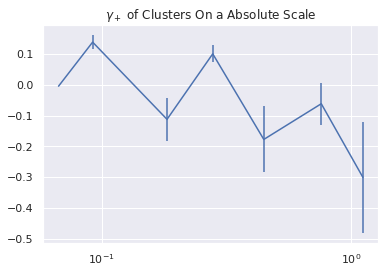

Aggregated xi:
[ 0.      0.      0.      0.0048 -1.1023  0.8972 -0.4993  3.8995  1.7275
  1.8001]
------------------------------------------------------------------------------
Aggregated meanlogr:
[  0.       0.       0.      -2.6983 -19.0744 -13.5932  -6.3902 -17.7692
  -7.7939   0.6306]
------------------------------------------------------------------------------
Aggregated npairs:
[ 0.  0.  0.  1.  8.  8.  5. 22. 28.  6.]
------------------------------------------------------------------------------
Mean xi:
[    nan     nan     nan  0.0048 -0.1378  0.1121 -0.0999  0.1772  0.0617
  0.3   ]
------------------------------------------------------------------------------
Mean meanlogr:
[    nan     nan     nan -2.6983 -2.3843 -1.6992 -1.278  -0.8077 -0.2784
  0.1051]
------------------------------------------------------------------------------


In [30]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

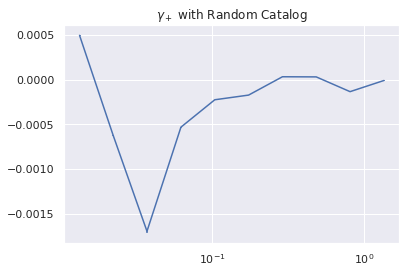

[ 4.9332e-04 -6.2438e-04 -1.6901e-03 -5.3002e-04 -2.2471e-04 -1.7261e-04
  3.1751e-05  3.0225e-05 -1.3427e-04 -1.0015e-05]
[-4.4173e-06  5.5909e-06  1.5134e-05  4.7459e-06  2.0121e-06  1.5456e-06
 -2.8431e-07 -2.7065e-07  1.2023e-06  8.9676e-08]


In [31]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

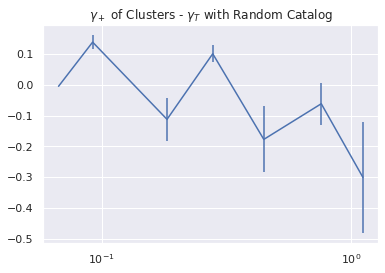

In [32]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

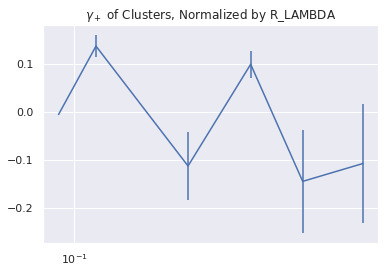

Aggregated xi:
[ 0.      0.      0.      0.      0.0048 -1.1023  0.8972 -0.4993  2.8844
  2.5674]
------------------------------------------------------------------------------
Aggregated meanlogr:
[  0.       0.       0.       0.      -2.4203 -17.0965 -11.5284  -4.8363
 -11.4769  -2.8437]
------------------------------------------------------------------------------
Aggregated npairs:
[ 0.  0.  0.  0.  1.  8.  8.  5. 20. 24.]
------------------------------------------------------------------------------
Mean xi:
[    nan     nan     nan     nan  0.0048 -0.1378  0.1121 -0.0999  0.1442
  0.107 ]
------------------------------------------------------------------------------
Mean meanlogr:
[    nan     nan     nan     nan -2.4203 -2.1371 -1.441  -0.9673 -0.5738
 -0.1185]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [33]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)